# Group Project 2024/25

### Task ###

Allenare un AE per Anomaly Detection in grado di riconoscere segnali prodotti da jeti adronici anomali in un reivelatore di fisica delle alte energie.

Alle energie estreme del Large Hadron Collider, particelle massive possono essere prodotte con un tale boost di Lorentz da far sì che i loro decadimenti in adroni (getti adronici) risultino così collimati che le particelle prodotte si sovrappongono. Determinare se la sottostruttura di un getto osservato sia dovuta a una singola particella di bassa massa oppure a molteplici prodotti di decadimento di una particella di massa elevata è un problema cruciale nell’analisi dei dati del LHC. Gli approcci tradizionali si basano su osservabili di alto livello costruite a partire da modelli teorici di deposizione di energia nei calorimetri e da parametri delle tracce cariche ricostruite nel tracciatore interno, ma la complessità dei dati rende questo compito un candidato ideale per l’applicazione di strumenti di deep learning. I costituenti dei getti possono infatti essere rappresentati come immagini 2D in cui ogni pixel rappresenta una delle celle sensibili del calorimetro, e il contenuto della cella una misura dell'energia o della quantità di moto depositata nella cella.

**Dataset:**

I dati del progetto sono nella forma di immagini 2D di dimensione (100,100), ogni cella rappresenta l'energia depositata in quella cella dalle particelle del jet adronico corrispondente. Ci sono due tipologie di jet adronici consider ati: *jet normali*, costituiti dalla adronizzazione di un quark leggero o gluone, e *jet anomali* (disponibili in una frazione incognita solo nel test set) costituiti dall'adronizzazione dei quark nel decadimento $t \to Wb \to qq'b$, in cui a causa del boost del quark top, i tre quark nello stato finale sono parzialmente sovrapposti.

* *Normal data dataset:* 12k jet rappresentati come histogrammi 2D della quantità di moto depositata in ciascuno dei 100x100 bin di una finestra quadrata nel piano ($\theta,\phi$) centrato intorno all'asse del jet.

* *Test dataset:*
due dataset costituiti ciascuno da 3k eventi, contenenti jet normali e jet anomali in una frazione relativa icognita da determinare. Nel primo dataset (*_high*) la frazione incognita di eventi anomali è $\ge 55\%$. Nel secondo dataset (*_low*) la frazione incognita di eventi anomali incognita è $\le 45\%$.
Potete utilizzare questa informazione per verificare che le vostre predizioni soddisfino la relazione $f_{high} > f_{low}$.

I dati sono forniti come array numpy in un file numpy compresso (.npz), leggibile con l'esempio di codice che segue:


```
import numpy as np

f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

normal_data = f_train['normal_data']
test_data_l = f_test_l['test_data']
test_data_h = f_test_h['test_data']

print(normal_data.shape)
print(test_data_l.shape)
print(test_data_h.shape)
```


**Obiettivi minimi del progetto (potete a vostro piacimento aggiungere ulteriori analisi/studi:**

1. Plot della rappresentazione latente delle immagini di test fatto con riduzione dimensionale.
2. Stima della frazione di eventi anomali presente nei due Test dataset, tenendo conto che la di procedura di stima deve garantire che la rate di falsi postivi sia inferiore a circa il $10\%$ (FPR $\le \sim 10\%$).
3. Clustering dello spazio (per esempio usando un algoritmo GMM).
4. Misura della purezza dei cluster rispetto alle label assegnate in anomaly score.


**Nota Importante:**

Il notebook deve essere compilato come una relazione scientifica del progetto, quindi deve contenere sia il codice (leggibile e riproducibile), i risultati in termini di grafici e tabelle numeriche, e il testo che illustra la strategia ottenuta, le scelte compiute, e i risultati ottenuti.



# Real

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.6.0+cu124


# Data management

In [ ]:
def get_data(group, flags = True):
  urls = {}

  for filename, url in urls.items():
    if not os.path.exists(filename):
      print(f'Downloading {filename}...')
      return_code = os.system(f'wget {url}')
      if return_code != 0:
        raise IOError(f'ERROR: failed to download {filename} from {url}')

  f_normal = np.load('Normal_data.npz')
  normal_data = f_normal['normal_data']
  f_low = np.load('Test_data_low.npz')
  test_data_l = f_low['test_data']
  f_high = np.load('Test_data_high.npz')
  test_data_h = f_high['test_data']

  if flags == True:
    print('Normal data: should be (12000, 100, 100)', normal_data.shape)
    print('Low anomalies data: should be (3000, 100, 100)', test_data_l.shape)
    print('High anomalies data: should be (3000, 100, 100)', test_data_h.shape)

  return normal_data[:, np.newaxis, :, :], test_data_l[:, np.newaxis, :, :], test_data_h[:, np.newaxis, :, :]

In [ ]:
normal, low, high = get_data(37)

Normal data: should be (12000, 100, 100) (12000, 100, 100)
Low anomalies data: should be (3000, 100, 100) (3000, 100, 100)
High anomalies data: should be (3000, 100, 100) (3000, 100, 100)


Si convertono i dati (np.array) in Torch Tensors delle giuste dimensioni per essere l'input di una CNN



In [ ]:
normal_t = torch.Tensor(normal)
low_t = torch.Tensor(low)
high_t = torch.Tensor(high)

print(normal_t.shape)
print(low_t.shape)
print(high_t.shape)

torch.Size([12000, 1, 100, 100])
torch.Size([3000, 1, 100, 100])
torch.Size([3000, 1, 100, 100])


Si effettua un plot preliminare di 1 immagine per ciascuno dei 3 dataset e si osserva che nel caso delle anomalie, trattandosi di quark sovrapposti, l'immagine presenta un cluster meno esteso e con celle cui è associata energia maggiore rispetto al caso "normale".

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


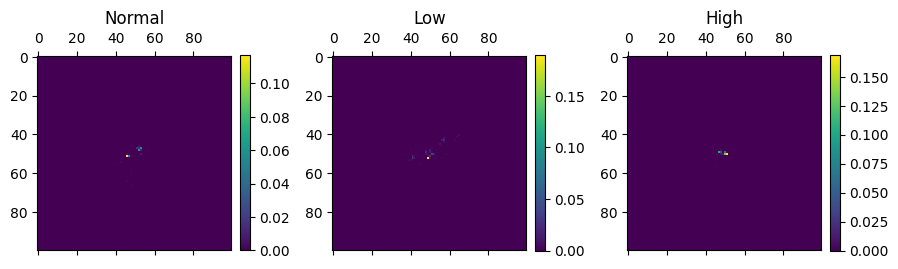

In [ ]:
def plot_random_example(n, l, h):
    idx_n = np.random.randint(0, n.shape[0])
    idx_l = np.random.randint(0, l.shape[0])
    idx_h = np.random.randint(0, h.shape[0])

    img_n = n[idx_n, 0].cpu().numpy()
    img_l = l[idx_l, 0].cpu().numpy()
    img_h = h[idx_h, 0].cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    im0 = ax[0].matshow(img_n, cmap='viridis')
    ax[0].set_title('Normal')
    fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].matshow(img_l, cmap='viridis')
    ax[1].set_title('Low')
    fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].matshow(img_h, cmap='viridis')
    ax[2].set_title('High')
    fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    for a in ax:
        a.axis('on')

    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()

plot_random_example(normal_t,low_t,high_t)


Si divide il dataset "normal" in un dataset di train (80% dei dati) e uno di test (20%) che si utilizzerà come ulteriore conferma del corretto funzionamento del modello.
Si utilizza Dataloaders per trasformare i 4 dataset grezzi (normal_train, normal_test, low_test, high_test) in iterabili, nel caso del dataset train in minibatch.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

batch_size = 64 #Dimensione dei batch ottimale per minimizzare l'oscillazione della loss e al tempo stesso evitare l'overfitting


dataset_n = TensorDataset(normal_t, normal_t) #Creazione del dataset in cui input e target sono sempre il dataset "normale"

test_frac = 0.2 #Splitting del dataset iniziale in train (0.8) e test
n_total = len(dataset_n)
n_test  = int(test_frac * n_total)
n_train = n_total - n_test

torch.manual_seed(42)
train, test = random_split(dataset_n, [n_train, n_test])

dataloader_n_train = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last = True)
dataloader_n_test = DataLoader(test, batch_size = 1)

dataset_h = TensorDataset(high_t, high_t)
dataloader_h = DataLoader(dataset_h, batch_size=1)

dataset_l = TensorDataset(low_t, low_t)
dataloader_l = DataLoader(dataset_l, batch_size=1)

# AE

Si definiscono encoder e decoder in modo simmetrico per comprimere le immagini (100*100) nello spazio latente. Scelti due layer convoluzionali per garantire un equilibrio tra compressione efficace e buona ricostruzione, evitando overfitting e mantenendo bassa la loss. Architetture più profonde (3 o più layers) non hanno portato a miglioramenti significativi.
Si effettua ottimizzazione manuale dei parametri di kernel_size e stride per permettere la cattura di segnali deboli e isolati su immagini sparse (quasi completamente nulle).
L'uso di BatchNorm è fondamentale per evitare il collasso del modello così come LeakyRelu che previene il problema di gradient vanishing.

In [ ]:

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=8):
        super().__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(1, hidden_channels, kernel_size = 6, stride=2, padding=1),  #Si sceglie per il primo layer una kernel size grande in modo da estrarre i pattern globali:
                                                                                  #la densità locale di informazione è bassa, è più importante avere un'idea sulla sua distribuzione
            nn.BatchNorm2d(hidden_channels ),
            nn.LeakyReLU(.01),

            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size = 2, stride = 1), #La dimensione del secondo kernel viene scelta minore rispetto al primo layer in modo da concentrarsi su dettagli locali
            nn.BatchNorm2d(hidden_channels * 2),
            nn.LeakyReLU(.01),

            nn.MaxPool2d(2, 2)

        )

        # Calcolo automatico della dimensione lineare finale
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 100, 100)
            out = self.conv(dummy)
            self.flattened_dim = out.numel()  # totale dei valori (C × H × W)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_dim, latent_dim),
            nn.LeakyReLU(.01),
        )



    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

#Si crea il decoder in modo simmetrico all'encoder
class Decoder(nn.Module):
    def __init__(self, flattened_dim, hidden_channels=64, latent_dim=8, ):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, flattened_dim ),
            nn.LeakyReLU(.01),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, kernel_size = 2, stride=2, output_padding = 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(.01),

            nn.ConvTranspose2d(hidden_channels, 1, kernel_size = 6, stride=2, padding=1),
            nn.Sigmoid()  #Output tra [0,1] per immagini normalizzate
        )

        self.H=int((flattened_dim/ ( hidden_channels*2 ) )**.5)

    def forward(self,z):
        z = self.fc(z).view(z.size(0), -1, self.H, self.H)
        return self.decoder(z)


Setup di AE

In [ ]:
#Si esegue autoencoder sui dataset e si stampa il riassunto del risultato
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reco = self.decoder(z)
        return x_reco

hidden_channels = 32 #Data la semplicità delle immagini, risulta sufficiente un valore relativamente basso, in modo da evitare overfitting
latent_dim = 4 #Anche se l'analisi della varianza spiegata suggerisce che solo 2 dimensioni latenti sono significative, si sceglie latent_dim = 4 per dare al modello più flessibilità nella codifica non lineare pur mantenendo elevata compressione.
encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(encoder.flattened_dim, hidden_channels=hidden_channels, latent_dim=latent_dim)

model_ae = AE(encoder, decoder)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,100,100))
else:
  summary(model_ae, input_size=(1,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 49, 49]           1,184
       BatchNorm2d-2           [-1, 32, 49, 49]              64
         LeakyReLU-3           [-1, 32, 49, 49]               0
            Conv2d-4           [-1, 64, 48, 48]           8,256
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         LeakyReLU-6           [-1, 64, 48, 48]               0
         MaxPool2d-7           [-1, 64, 24, 24]               0
           Flatten-8                [-1, 36864]               0
            Linear-9                    [-1, 4]         147,460
        LeakyReLU-10                    [-1, 4]               0
          Encoder-11                    [-1, 4]               0
           Linear-12                [-1, 36864]         184,320
        LeakyReLU-13                [-1, 36864]               0
  ConvTranspose2d-14           [-1, 32,

# Training + analisi

Si sceglie come metodo di train la BCE perchè più indicata, rispetto MSE,quando in output si ha una funzione sigmoide. In questo modo l'output può essere interpretato in termini probabilistici (i valori sono compressi tra 0 e 1), è dunque sensato misurare la distanza tra la distribuzione di probabilità dell’output e quella dell’input originale.

In [ ]:
loss_func = nn.BCELoss()
from torch import optim
LR = 1 * 10**-3
opt = torch.optim.Adam(params = model_ae.parameters(), lr=LR, weight_decay=1e-5)

Si effettua l'allenamento del modello con epoche=20 in quanto si osserva una
diminuzione della loss fino ad una stabilizzazione, un numero maggiore avrebbe portato a rischio di overfitting e aumento dei tempi di training.
Si riporta il grafico della Loss in funzione delle epoche a fini esplicativi.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.073094 - Time: 2.55s
Epoch 2/20 - Loss: 0.003546 - Time: 2.06s
Epoch 3/20 - Loss: 0.001691 - Time: 2.07s
Epoch 4/20 - Loss: 0.001108 - Time: 2.07s
Epoch 5/20 - Loss: 0.000841 - Time: 2.08s
Epoch 6/20 - Loss: 0.000693 - Time: 2.11s
Epoch 7/20 - Loss: 0.000600 - Time: 2.09s
Epoch 8/20 - Loss: 0.000539 - Time: 2.10s
Epoch 9/20 - Loss: 0.000495 - Time: 2.11s
Epoch 10/20 - Loss: 0.000458 - Time: 2.11s
Epoch 11/20 - Loss: 0.000434 - Time: 2.13s
Epoch 12/20 - Loss: 0.000418 - Time: 2.14s
Epoch 13/20 - Loss: 0.000407 - Time: 2.14s
Epoch 14/20 - Loss: 0.000397 - Time: 2.14s
Epoch 15/20 - Loss: 0.000389 - Time: 2.14s
Epoch 16/20 - Loss: 0.000383 - Time: 2.15s
Epoch 17/20 - Loss: 0.000377 - Time: 3.74s
Epoch 18/20 - Loss: 0.000373 - Time: 2.99s
Epoch 19/20 - Loss: 0.000369 - Time: 2.46s
Epoch 20/20 - Loss: 0.000365 - Time: 2.18s


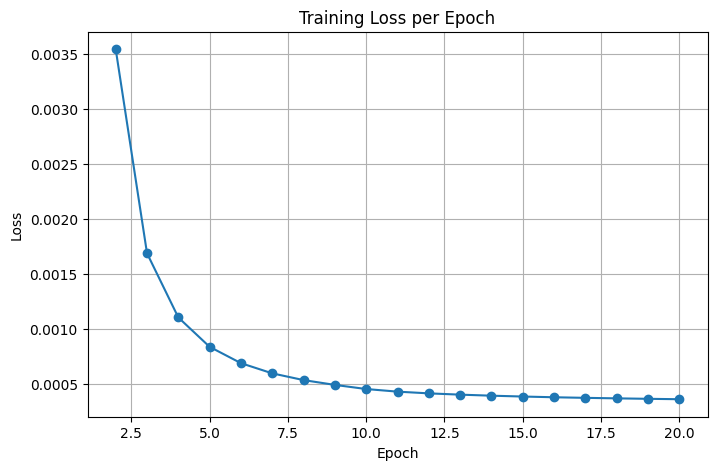

In [ ]:
import time

epochs = 20
loss_per_epoch = []

for epoch in tqdm(range(epochs)):
  t0 = time.time()
  model_ae.train()
  train_loss = 0
  count = 0
  for xb, _ in dataloader_n_train:
    count += 1
    xb = xb.to(device)
    xhat = model_ae(xb)
    loss = loss_func(xhat, xb)
    train_loss += loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  train_loss /= count
  print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.6f} - Time: {time.time()-t0:.2f}s")

  loss_per_epoch.append(train_loss)

# Plot della loss per epoca
plt.figure(figsize=(8,5))
plt.plot(np.arange(2, epochs+1), loss_per_epoch[1:], marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Si riportano alcuni esempi di visualizzazione di input - output della rete, a conferma del suo corretto funzionamento e come check della qualità della ricostruzione.
Si osserva inoltre che le anomalie vengono ricostruite in modo migliore (a livello qualitativo) dei dati normali.

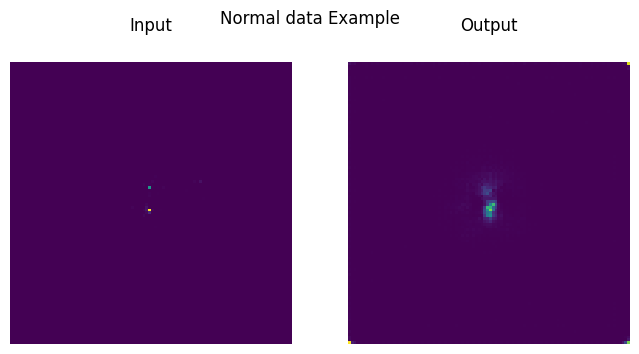

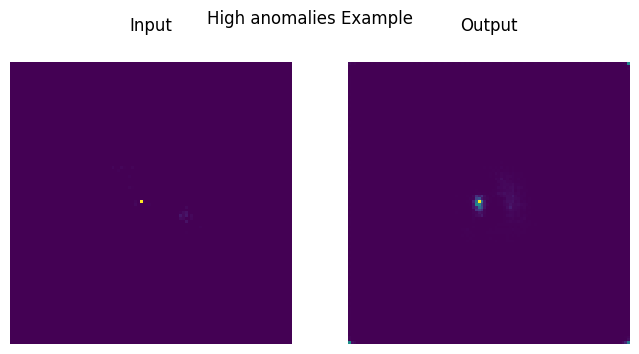

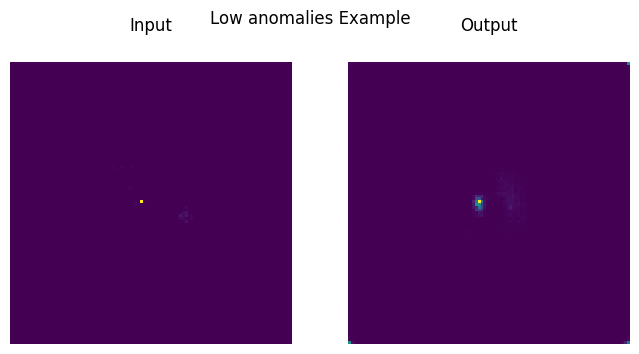

In [ ]:

import random

def show_input_output(model, dataloader, device, num_examples = 1, title="Dataset"):
    model.to(device)
    model.eval()

    with torch.no_grad():
        data_iter = iter(dataloader)
        xb, _ = next(data_iter)

        xb = xb.to(device)
        pred = model(xb)

        xb = xb.cpu()
        pred = pred.cpu()
        n = random.randint(0, xb.shape[0] - 1)

        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        axs[0].matshow(xb[n,0])
        axs[0].set_title('Input')
        axs[0].axis('off')
        axs[1].matshow(pred[n,0])
        axs[1].set_title('Output')
        axs[1].axis('off')
        plt.suptitle(f'{title} Example')
        plt.show()



show_input_output(model_ae, dataloader_n_test, device, num_examples=1, title="Normal data")
show_input_output(model_ae, dataloader_h, device, num_examples=1, title="High anomalies")
show_input_output(model_ae, dataloader_l, device, num_examples=1, title="Low anomalies")

Calcolo dello spazio latente, in modo da ottenere la loss su ogni singolo campione (e non sulla media di essi), per ciascuno dei 4 dataset analizzati, riduzione ad un unico tensore (per poter effettuare riduzione dimensionale e GMM successivamente).
Si calcola poi il centroide dei dati normali e la matrice di covarianza associata (regolarizzata per garantire la stabilità numerica dell’inversione e quindi la matrice di precisione).

In [ ]:
model_ae.to(device)
model_ae.eval()

def latent(dataloader, Z):# Calcola lo spazio latente per i campioni in un DataLoader
  with torch.no_grad():
    for xb, _ in dataloader:
      xb = xb.to(device)
      z = model_ae.encoder(xb)
      Z.append(z.cpu())
Z_h, Z_l, Z_n_train, Z_n_test = [], [], [], []
latent(dataloader_h, Z_h)
latent(dataloader_l, Z_l)
latent(dataloader_n_train, Z_n_train)
latent(dataloader_n_test, Z_n_test)

Z_h = torch.cat(Z_h, dim=0)
Z_l = torch.cat(Z_l, dim=0)
Z_n_train = torch.cat(Z_n_train, dim=0)
Z_n_test = torch.cat(Z_n_test, dim=0)

Z_all = torch.cat([Z_h, Z_n_train, Z_n_test, Z_l], dim = 0)
print(Z_all.shape)

centroid = Z_n_train.mean(dim=0)

covariance_mat = torch.cov(Z_n_train.T)

epsilon = 1e-6
covariance_mat = covariance_mat + torch.eye(covariance_mat.shape[0]) * epsilon

precision_mat = torch.linalg.inv(covariance_mat)

torch.Size([18000, 4])


Sono stati calcolati due tipi di anomaly score: la loss di ricostruzione, che misura l’errore pixel-per-pixel tra input e output dell’autoencoder, e la distanza di Mahalanobis (nel caso di matrice di precisione diagonale, peso le distanze normalizzate alla varianza nella direzione corrispondente) nello spazio latente, che quantifica quanto un embedding è lontano dal comportamento normale. Si effettua dunque un confronto tra i due risultati.

In [ ]:
def calculate_reconstruction_loss(dataloader, model_ae, loss_func, device):#Calcolo delle loss di ricostruzione per tutti i campioni in un dataloader e restituisce un tensore CPU delle loss per singolo campione.
  losses = []
  loss_func = nn.MSELoss()  # Preferita MSE a BCE per la migliore capacità di classificazione sfruttando un criterio di threshold
  with torch.no_grad():
    for xb, _ in dataloader:
      xb = xb.to(device)
      xhat = model_ae(xb)
      loss = loss_func(xhat, xb)
      losses.append(loss.item())
  return np.array(losses)

def calculate_mahalanobis_distance(Z_embeddings, centroid, precision_matrix):
  diff = Z_embeddings - centroid

  term1 = torch.matmul(diff, precision_matrix)

  mahalanobis_sq = torch.sum(term1 * diff, dim=1) # (X-mu)^T * Prec_mat * (X-mu)

  mahalanobis_dist = torch.sqrt(mahalanobis_sq)
  return mahalanobis_dist


loss_h, loss_l, loss_n_train, loss_n_test = [], [], [], []
dist_h, dist_l, dist_n_train, dist_n_test = [], [], [], []


print("Calcolo delle loss di ricostruzione")
loss_h = calculate_reconstruction_loss(dataloader_h, model_ae, loss_func, device)
loss_l = calculate_reconstruction_loss(dataloader_l, model_ae, loss_func, device)
loss_n_train = calculate_reconstruction_loss(dataloader_n_train, model_ae, loss_func, device)
loss_n_test = calculate_reconstruction_loss(dataloader_n_test, model_ae, loss_func, device)

print(f"Loss H (media) +- (std): {loss_h.mean():.6f} +- {loss_h.std():.6f}, Errore relativo:({loss_h.std()/loss_h.mean():.2f})")
print(f"Loss L (media) +- (std): {loss_l.mean():.6f} +- {loss_l.std():.6f}, Errore relativo:({loss_l.std()/loss_l.mean():.2f})")
print(f"Loss N_Train (media) +- (std): {loss_n_train.mean():.6f} +- {loss_n_train.std():.6f}, Errore relativo:({loss_n_train.std()/loss_n_train.mean():.2f})")
print(f"Loss N_Test (media) +- (std): {loss_n_test.mean():.6f} +- {loss_n_test.std():.6f}, Errore relativo:({loss_n_test.std()/loss_n_test.mean():.2f})")


print("\nCalcolo delle distanze di Mahalanobis nello spazio latente")
dist_h = calculate_mahalanobis_distance(Z_h, centroid, precision_mat)
dist_l = calculate_mahalanobis_distance(Z_l, centroid, precision_mat)
dist_n_train = calculate_mahalanobis_distance(Z_n_train, centroid, precision_mat)
dist_n_test = calculate_mahalanobis_distance(Z_n_test, centroid, precision_mat)

print(f"Distanza H (media) +- (std): {dist_h.mean():.4f} +- {dist_h.std():.4f}, Errore relativo:({dist_h.std()/dist_h.mean():.2f})")
print(f"Distanza L (media) +- (std): {dist_l.mean():.4f} +- {dist_l.std():.4f}, Errore relativo:({dist_l.std()/dist_l.mean():.2f})")
print(f"Distanza N_Train (media) +- (std): {dist_n_train.mean():.4f} +- {dist_n_train.std():.4f}, Errore relativo:({dist_n_train.std()/dist_n_train.mean():.2f})")
print(f"Distanza N_Test (media) +- (std): {dist_n_test.mean():.4f} +- {dist_n_test.std():.4f}, Errore relativo:({dist_n_test.std()/dist_n_test.mean():.2f})")

Calcolo delle loss di ricostruzione
Loss H (media) +- (std): 0.000014 +- 0.000008, Errore relativo:(0.62)
Loss L (media) +- (std): 0.000005 +- 0.000005, Errore relativo:(1.06)
Loss N_Train (media) +- (std): 0.000003 +- 0.000000, Errore relativo:(0.08)
Loss N_Test (media) +- (std): 0.000003 +- 0.000002, Errore relativo:(0.58)

Calcolo delle distanze di Mahalanobis nello spazio latente
Distanza H (media) +- (std): 5.0136 +- 1.7234, Errore relativo:(0.34)
Distanza L (media) +- (std): 2.1511 +- 1.5716, Errore relativo:(0.73)
Distanza N_Train (media) +- (std): 1.6044 +- 0.6876, Errore relativo:(0.43)
Distanza N_Test (media) +- (std): 1.6062 +- 0.6845, Errore relativo:(0.43)


**Commenti:** Si osserva come i valori medi e varianze di loss per i dataset di train e test coincidano ragionevolmente. Deduciamo dunque che il modello generalizzi anche su un dataset su cui non è stato allenato.
Come previsto l'AE ricostruisce con loss maggiore gli eventi anomali, visto che loss_h_mean>loss_l_mean>loss_n_mean.

Si procede con il calcolo delle anomalie in entrambi i modi imponendo un trashold pari al 90° percentile, in modo da rispettare la richiesta di un FPR≤∼ 10% .

In [ ]:
def find_anomalies(n_train, n_test, h, l, score_type = 'Loss (MSE)', figure = True, ylog = False, y_max=1):

  n_train = np.array(n_train)
  n_test = np.array(n_test)
  h = np.array(h)
  l = np.array(l)

  threshold = np.percentile(n_train, 90)

  labels_n_train = (n_train >= threshold).astype(int)
  labels_n_test = (n_test >= threshold).astype(int)
  labels_l = (l >= threshold).astype(int)
  labels_h = (h >= threshold).astype(int)

  frac_n_train = labels_n_train.mean()
  frac_n_test = labels_n_test.mean()
  frac_l = labels_l.mean()
  frac_h = labels_h.mean()

  if figure:
    min = np.min(np.concatenate([n_train, n_test, h, l]))
    max = np.max(np.concatenate([n_train, n_test, h, l]))


    plt.title(f'FPR: | $f_{{train}}= {frac_n_train:.2f}$ | $f_{{test}}= {frac_n_test:.2f} $ | $f_{{low}} = {frac_l:.2f}$ | $f_{{high}} = {frac_h:.2f}$')
    plt.vlines(x = threshold, ymin = 0, ymax = y_max, color = 'red', ls = '-.', label = 'Anomaly score threshold')
    _ = plt.hist(n_train, bins = 100, alpha=0.5, range = [min, max], density = True, label = 'Train')
    _ = plt.hist(n_test, bins = 100, alpha=0.5, range = [min, max], density = True, label = 'Test')
    _ = plt.hist(h, bins = 100, alpha=0.5, range = [min, max], density = True, label = 'High')
    _ = plt.hist(l, bins = 100, alpha=0.5, range = [min, max], density = True, label = 'Low')
    plt.xlabel(score_type)
    plt.ylabel('Entries normalizzate')
    plt.grid(True, alpha = .3)
    if ylog:
      plt.yscale('log')
    plt.legend()
    plt.show()

  return labels_n_train, labels_n_test, labels_l, labels_h


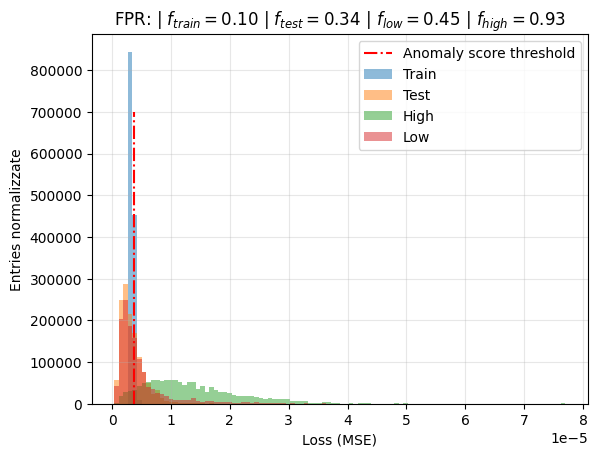

In [ ]:
loss_labels_train, loss_labels_test, loss_labels_low, loss_labels_high = find_anomalies(loss_n_train, loss_n_test, loss_h, loss_l,y_max=700000)

**Commenti:** Si osserva che, dato il threshold di loss fissato tale che $ f_{train}=0.1$, c'è ragionevole corrispondenza tra quest'ultima e $f_{test}$.  Le percentuali $f_{low}, f_{high}$ risultano compatibili con quelle previste dalla traccia.

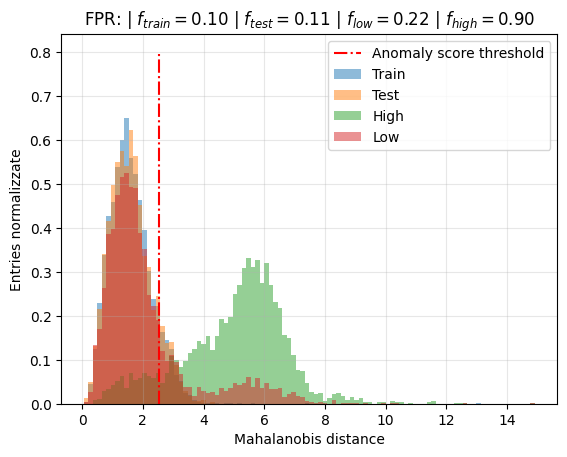

In [ ]:
dist_labels_train, dist_labels_test, dist_labels_low, dist_labels_high = find_anomalies(dist_n_train, dist_n_test, dist_h, dist_l, score_type="Mahalanobis distance",y_max=0.8)

**Commenti:** Le percentuali di anomalie su tutti i dataset analizzati sono anche in questo caso compatibili con quelle della traccia. Risulta tuttavia maggiore separazione tra le distanze tipiche di eventi normali e non (come si evince dalla presenza di due picchi ben separati e riconoscibili).

Si effettua poi PCA sullo spazio latente per la visualizzazione del rappresentazione latente delle immagini di test, in cui si osserva una ragionevole clusterizzazione.
Si effettua lo stesso procedimento anche con UMAP, più indicato in questo caso in quanto preserva la struttura dei dati anche in presenza di relazioni non lineari e facilita la separazione visiva tra dati normali e anomali nello spazio bidimensionale.

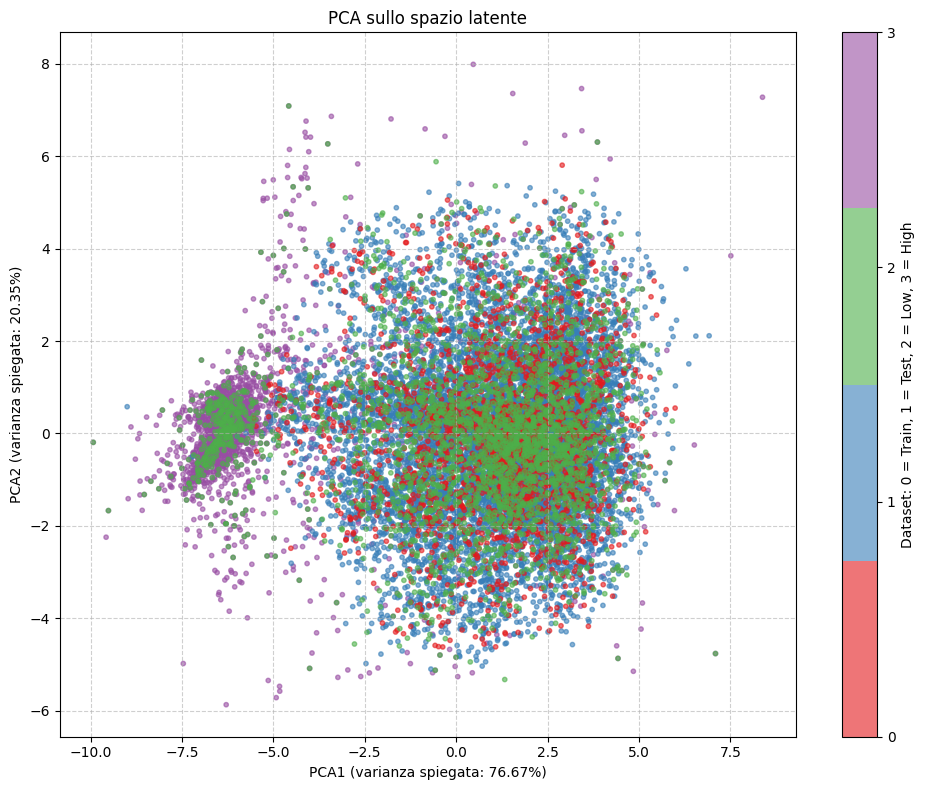

Varianza spiegata da ciascun componente:
PC1: 76.67%
PC2: 20.35%
PC3: 2.99%
PC4: 0.00%

Totale varianza spiegata: 100.00%
Varianza spiegata dai primi 2 componenti: 97.01%


In [ ]:
from matplotlib.colors import ListedColormap
import seaborn as sns

Z_all_np = Z_all.numpy()

labels = np.concatenate([
    np.full(len(Z_h), 3),
    np.full(len(Z_n_train), 1),
    np.full(len(Z_n_test), 0),
    np.full(len(Z_l), 2)
])

pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z_all_np)

colors = plt.get_cmap('Set1').colors[:4]


cmap = ListedColormap(colors)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c = labels, cmap = cmap, s=10, alpha=0.6)
plt.title('PCA sullo spazio latente')
plt.xlabel(f'PCA1 (varianza spiegata: {pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PCA2 (varianza spiegata: {pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.colorbar(scatter, ticks=[0, 1, 2, 3], label='Dataset: 0 = Train, 1 = Test, 2 = Low, 3 = High')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#Si calcola ora la varianza spiegata da ciascun componente e si osserva che solo i primi due forniscono un contributo non nullo
pca_full = PCA()
pca_full.fit(Z_all)
print("Varianza spiegata da ciascun componente:")
for i, v in enumerate(pca_full.explained_variance_ratio_):
    print(f"PC{i+1}: {v*100:.2f}%")

#Calcolo della varianza cumulativa a conferma della correttezza del modello
print(f"\nTotale varianza spiegata: {pca_full.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Varianza spiegata dai primi 2 componenti: {sum(pca_full.explained_variance_ratio_[:2])*100:.2f}%")

Visualizzazione tramite UMAP

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


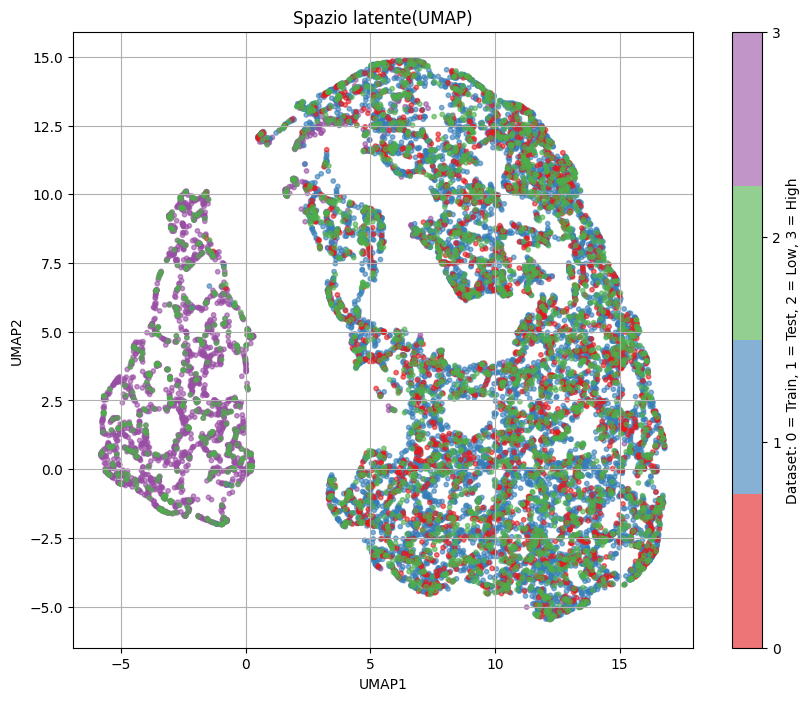

In [ ]:
try:
    import umap
except ImportError:
    print("umap-learn not found, installing now...")
    !pip install umap-learn
    import umap
    print("umap-learn installed successfully.")

reducer = umap.UMAP(n_components = 2, random_state = 42)
Z_umap = reducer.fit_transform(Z_all_np)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c = labels, cmap = cmap, s = 10, alpha = 0.6)
plt.colorbar(scatter, ticks=[0, 1, 2, 3], label='Dataset: 0 = Train, 1 = Test, 2 = Low, 3 = High')
plt.title("Spazio latente(UMAP)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.show()

**Commenti:** Con entrambi i metodi si ottengono risultati analoghi,
si individuano graficamente due cluster distinti:


1.   Uno di dimensioni maggiori contenente punti appartenenti a tutti i dataset;
2.   Il secondo di dimensioni minori a cui partecipano solo eventi dei dataset misti, con densità maggiore di punti appartenenti ad "high".


Si deduce quindi che il secondo cluster sia quello corrispondente agli embeddings delle anomalie.



In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, adjusted_rand_score, normalized_mutual_info_score

def purity_score(y_true, y_pred):
    from scipy.stats import mode
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        labels[mask] = mode(y_true[mask]).mode
    return np.mean(labels == y_true)

Clusterizzazione tramite GMM e calcolo della purezza per entrambe le label (loss e distanza)

**Obiettivo:** Effettuare classificazione tramite clusterizzazione GMM. Confrontare i risultati con quelli di anomaly score = Loss + Mahalanobis distance.

**Strategia 1:** Si esegue un algoritmo GMM sullo spazio latente del dataset di train. Ci si aspetta un solo cluster vista la presenza di soli dati normali. Imponendo FPR ≤∼ 10% sul dataset di train si stima un threshold per la log_likelihood relativa alla singola distribuzione gaussiana fittata.
Si stimano le frazioni di anomalie per i dataset rimanenti usando suddetta threshold.

In [ ]:
gmm_norm = GaussianMixture(n_components = 1, random_state = 42)
gmm_norm.fit(Z_n_train.numpy())

ll_train = gmm_norm.score_samples(Z_n_train.numpy())
threshold = np.percentile(ll_train, 10)
labels_ll_train = (ll_train < threshold).astype(int)

ll_test = gmm_norm.score_samples(Z_n_test.numpy())
labels_ll_test = (ll_test < threshold).astype(int)

ll_low = gmm_norm.score_samples(Z_l.numpy())
labels_ll_low = (ll_low < threshold).astype(int)

ll_high = gmm_norm.score_samples(Z_h.numpy())
labels_ll_high = (ll_high < threshold).astype(int)

labels_ll_all = np.concatenate([labels_ll_high, labels_ll_train, labels_ll_test, labels_ll_low])

print("--- Analisi delle log likelihood ---")
print(f"Loss H (media) +- (std): {ll_high.mean():.3f} +- {ll_high.std():.3f}")
print(f"Loss L (media) +- (std): {ll_low.mean():.3f} +- {ll_low.std():.3f}")
print(f"Loss N_Train (media) +- (std): {ll_train.mean():.6f} +- {ll_train.std():.6f}")
print(f"Loss N_Test (media) +- (std): {ll_test.mean():.6f} +- {ll_test.std():.6f}")

print("\n--- Stima delle frazioni di anomalie ---:")
print(f"f_test == FPR_test (should be ≈ .1): {labels_ll_test.mean():.3f}")
print(f"f_low (should be <≈ .45): {labels_ll_low.mean():.3f}")
print(f"f_high (should be >≈ .55):: {labels_ll_high.mean():.3f}")

print("\n—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (loss) ---")
print(f"Precision_low: {purity_score(loss_labels_low, labels_ll_low):.3f}")
print(f"Precision_high: {purity_score(loss_labels_high, labels_ll_high):.3f}")

print("\n—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (dist) ---")
print(f"Precision_low: {purity_score(dist_labels_low, labels_ll_low):.3f}")
print(f"Precision_high: {purity_score(dist_labels_high, labels_ll_high):.3f}")

--- Analisi delle log likelihood ---
Loss H (media) +- (std): -11.316 +- 8.753
Loss L (media) +- (std): -0.810 +- 6.213
Loss N_Train (media) +- (std): 1.215009 +- 1.536654
Loss N_Test (media) +- (std): 1.214312 +- 1.253719

--- Stima delle frazioni di anomalie ---:
f_test == FPR_test (should be ≈ .1): 0.110
f_low (should be <≈ .45): 0.222
f_high (should be >≈ .55):: 0.896

—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (loss) ---
Precision_low: 0.733
Precision_high: 0.934

—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (dist) ---
Precision_low: 1.000
Precision_high: 1.000


**Commenti 1:**
*   Le log_likelihood medie sono ordinate come ci si attende. In particolare, a ulteriore conferma delle capacità di generalizzazione del modello, notiamo come siano ragionevolmente compatibili quelle di train e test. Analoghe valutazioni per le frazioni di anomalie stimate.
*   Per quanto riguarda le purezze, si ottengono risultati soddisfacenti con le label di anomaly score calcolate con threshold su errore di ricostruzione. La perfetta coincidenza della clusterizzazione (purezza=1) col metodo "dist" non è un criterio adeguato per valutarne la bontà, in quanto non sono due metodi realmente indipendenti: di fatto la log_likelihood di una singola distribuzione gaussiana è proporzionale alla distanza di Mahalanobis.

**Strategia 2:** Si esegue un algoritmo GMM sullo spazio latente dell'intero dataset (normal_train + normal_test + high + low). Ci si aspettano due cluster vista la presenza di dati normali e anomali, questi ultimi in proporzioni data la grandezza del dataset normal. Si effettua anche la clusterizzazione tramite GMM. Si etichetta come cluster delle anomalie quello con cardinalità minore, effettuando così classificazione.

In [ ]:
gmm_mixed = GaussianMixture(n_components = 2, random_state = 42)
gmm_mixed.fit(Z_all.numpy())

cl_train = gmm_mixed.predict(Z_n_train.numpy())
cl_test = gmm_mixed.predict(Z_n_test.numpy())
cl_low = gmm_mixed.predict(Z_l.numpy())
cl_high = gmm_mixed.predict(Z_h.numpy())
cl_all = gmm_mixed.predict(Z_all.numpy())

# Determina quale cluster è più "anomalo"
anom_cluster = ( cl_all.mean() < 0.5 ).astype(int) #perché allenato su z_all (anomalie in frazione minore)

labels_cl_train = (cl_train == anom_cluster).astype(int)
labels_cl_test = (cl_test == anom_cluster).astype(int)
labels_cl_low = (cl_low == anom_cluster).astype(int)
labels_cl_high = (cl_high == anom_cluster).astype(int)
label_cl_all = (cl_all == anom_cluster).astype(int)

print("--- Stima delle frazioni di anomalie ---:")
print(f"f_train == FPR_train : {labels_cl_train.mean():.3f}")
print(f"f_test == FPR_test : {labels_cl_test.mean():.3f}")
print(f"f_low (should be <≈ .45): {labels_cl_low.mean():.3f}")
print(f"f_high (should be >≈ .55): {labels_cl_high.mean():.3f}")

print("\n—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (loss) ---")
print(f"Precision_low: {purity_score(loss_labels_low, labels_cl_low):.3f}")
print(f"Precision_high: {purity_score(loss_labels_high, labels_cl_high):.3f}")

print("\n—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (dist) ---")
print(f"Precision_low: {purity_score(dist_labels_low, labels_cl_low):.3f}")
print(f"Precision_high: {purity_score(dist_labels_high, labels_cl_high):.3f}")


--- Stima delle frazioni di anomalie ---:
f_train == FPR_train : 0.004
f_test == FPR_test : 0.008
f_low (should be <≈ .45): 0.122
f_high (should be >≈ .55): 0.718

—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (loss) ---
Precision_low: 0.674
Precision_high: 0.934

—--Purezza della classificazione tramite clutering GMM rispetto alle label di anomaly score (dist) ---
Precision_low: 0.900
Precision_high: 0.896


**Commenti 2:**
*   Le frazioni di anomalie stimate per i dataset normal_train/test risultano significativamente minori del 10%; il risultato non ci sorprende, non avendo imposto alcun threshold sul numero di eventi normali da stimare come anomali e lasciando la GMM clusterizzare liberamente.
*   Per quanto riguarda le purezze, l'anomaly score "dist" risulta essere in maggiore accordo rispetto a quello di tipo "loss", specialmente sul dataset low. Ciò supporta ulteriormente e definitivamente la migliore capacità di anomaly detection del metodo "dist".

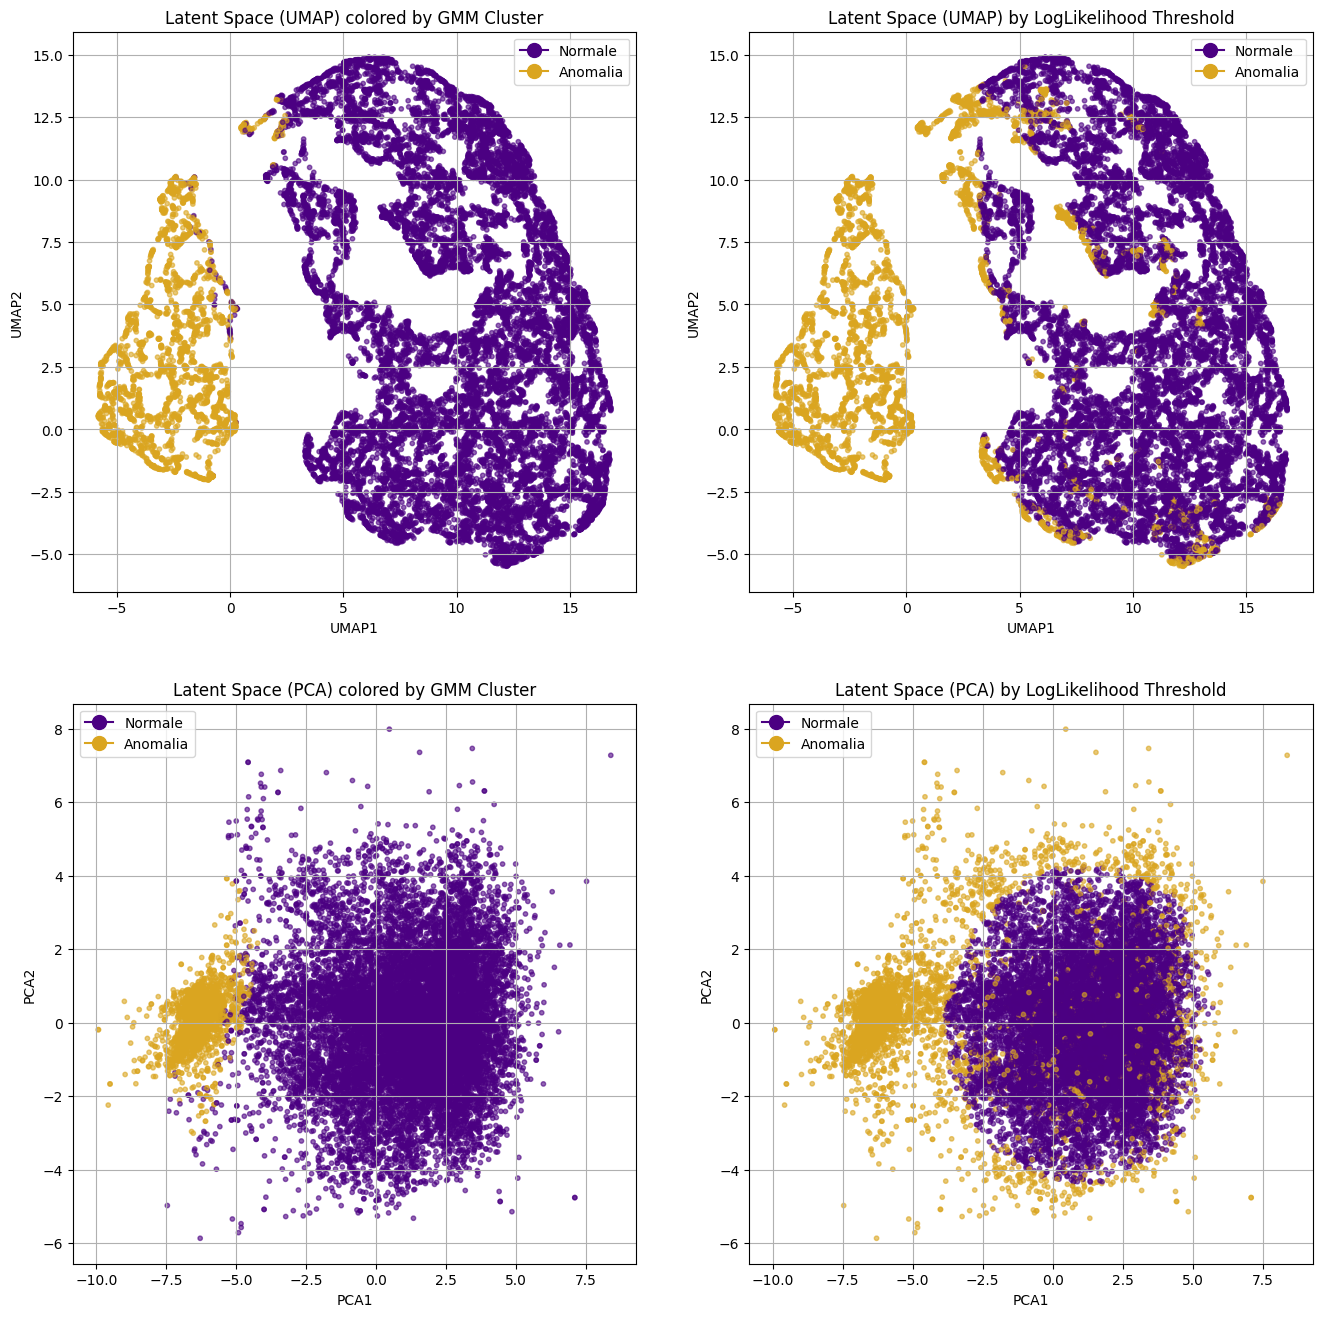

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(2, 2, figsize=(16,16))

cluster_colors = {0: '#4B0082', 1: '#DAA520'}
legend_elements = [
    Line2D([0], [0], marker='o', color='#4B0082', label='Normale',
           markerfacecolor=cluster_colors[0], markersize=10),
    Line2D([0], [0], marker='o', color='#DAA520', label='Anomalia',
           markerfacecolor=cluster_colors[1], markersize=10)
]

cluster_labels = label_cl_all
ax[0][0].scatter(Z_umap[:, 0], Z_umap[:, 1], c=[cluster_colors[i] for i in cluster_labels], s=10, alpha=0.6)
ax[0][0].set_title("Latent Space (UMAP) colored by GMM Cluster")
ax[0][0].set_xlabel("UMAP1")
ax[0][0].set_ylabel("UMAP2")
ax[0][0].legend(handles=legend_elements)
ax[0][0].grid(True)

ax[1][0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=[cluster_colors[i] for i in cluster_labels], s=10, alpha=0.6)
ax[1][0].set_title("Latent Space (PCA) colored by GMM Cluster")
ax[1][0].set_xlabel("PCA1")
ax[1][0].set_ylabel("PCA2")
ax[1][0].legend(handles=legend_elements)
ax[1][0].grid(True)

cluster_labels = labels_ll_all
ax[0][1].scatter(Z_umap[:, 0], Z_umap[:, 1], c=[cluster_colors[i] for i in cluster_labels], s=10, alpha=0.6)
ax[0][1].set_title("Latent Space (UMAP) by LogLikelihood Threshold")
ax[0][1].set_xlabel("UMAP1")
ax[0][1].set_ylabel("UMAP2")
ax[0][1].legend(handles=legend_elements)
ax[0][1].grid(True)

ax[1][1].scatter(Z_pca[:, 0], Z_pca[:, 1], c=[cluster_colors[i] for i in cluster_labels], s=10, alpha=0.6)
ax[1][1].set_title("Latent Space (PCA) by LogLikelihood Threshold")
ax[1][1].set_xlabel("PCA1")
ax[1][1].set_ylabel("PCA2")
ax[1][1].legend(handles=legend_elements)
ax[1][1].grid(True)


Il metodo con threshold sulla log-likelihood è equivalente a quello con distanza Mahalanobis. Visivamente, i risultati sono simili, specialmente in grafico UMAP, con la clusterizzazione integralmente GMM che isola un cluster più piccolo e, visivamente, risulta essere in effetti più efficace. Dal momento che tutte le anomalie individuate con GMM sono individuate anche da quello con threshold, il primo potrebbe essere utilizzato per effettuare un lavoro di tuning sul threshold e ottimizzare i risultati del secondo classificatore.